# Brad Evans: Flame-bait or Lame-bait? (it's a working title, ok?)

[Blurb on why I'm doing this.]

## Methodology

Since Yahoo went with the infinite scrolling UI, pulling up old articles directly from the site became impossible. Thankfully there's Google. Using the following Google search, I can pull back every Flame/Lame call Brad has ever made:

site:sports.yahoo.com/blogs/fantasy-roto-arcade intitle:flames +2012 "Week 10"

site:sports.yahoo.com/blogs/fantasy-roto-arcade intitle:lames +2010 "Week 6"

There is a little manual work involved. Basically, I clicked to the last search result page, and clicked the link that said 

In order to show you the most relevant results, we have omitted some entries very similar to the 85 already displayed.
If you like, you can repeat the search with the omitted results included.

After passing all the captcha tests to prove to google and myself that I was human, I proceeded to Ctrl+A Ctrl+C each page of search results. Google obfuscates URLs, but thankfully, Yahoo's were just the right length for inferrance -

I also used Twitter and Internet Archive: 

flames OR lames @yahoonoise since:2011-01-01 until:2012-01-1

Basically, just use this regex in Vim, and you've got yourself a workable URL. 

:%s/\/\.\.\.\//\/blogs\/fantasy-roto-arcade\//



Yahoo's formats were terribly inconsistent. Bloated. 
Handling Updates.
Brad was a little more fearful early on (2010), suggesting a list of potential flames/lames in addition to his fearless forecasts.
Brad is mostly concerned with flames for 12-man leagues and deaper (prove this)
Under what conditions is Brad usually correct?

SHOCKER SPECIAL
BONUS SHOCKER (2011- week 2)
Attempting to fix missing data by padding with prefixes

Brad definitely didn't make this to be machine readable

A sample of formats (after heavily pre-processed) looks like this:

2009 
Josh Freeman, TB, QB (Noise QB Rank: 11, Start: 12-plus team leagues, 2% started)
Matchup: vs. NO
[WITTY BLURB]
Fearless Forecast: 19-33, 217 passing yards, 2 touchdowns, 1 interception, 24 rushing yards, 19 fantasy points

2010
Thomas Jones, KC, RB (Noise Week 11 RB Rank: 17, 53-percent started)
Matchup: vs. Ari
[WITTY BLURB]
Fearless Forecast: 19 carries, 95 rushing yards, 1 receptions, 4 receiving yards, 1 touchdown, 15 fantasy points

2011
Ben Tate, Hou, RB (Week 3 Noise RB Rank: 9, 22-percent started)
Matchup: at NO
[WITTY BLURB]
Fearless Forecast: 25 carries, 119 rushing yards, 4 receptions, 24 receiving yards, 1 touchdown, 23.3 fantasy points

2011
Michael Vick, Phi, QB (Noise Week 11 QB Rank: 13, 72-percent started)
Matchup: at NYG
[WITTY BLURB]
Fearless Forecast: 17-29, 193 passing yards, 1 touchdown, 2 interceptions, 27 rushing yards, 14.4 fantasy points

2012
Willis McGahee, Den, RB (78-percent started)
Matchup: vs. SD
[WITTY BLURB]
Fearless Forecast: 17 carries, 62 rushing yards, 3 receptions 21 receiving yards, 0 touchdowns, 10.5 fantasy points

2013
Matt Ryan, Atl, QB (53-percent started)
Matchup: at TB
[WITTY BLURB]
Fearless Forecast: 241 passing yards, 1 passing touchdown, 2 interceptions, 5 rushing yards, 14.5 fantasy points

2014
Ben Roethlisberger, Pit, QB (60 percent started)
Matchup: at Ten
[WITTY BLURB]
Fearless Forecast: 25-39, 266 passing yards, 1 passing touchdown, 1 interception, 16.3 fantasy points

2015
Matt Jones, Was, RB (10 percent started, $17)
Matchup: at NYG
[WITTY BLURB]
Fearless Forecast: 13 carries, 66 rushing yards, 3 receptions, 14 receiving yards, 1 touchdown, 15.5 fantasy points

This is fairly consistent now. The major difference going from 2009 to 2015, is in the rank. We start out with a "Noise Rank", and a league depth gague, but eventually just come down to a percent started, and this year, a dollar value added (for FanDuel, no doubt). 

Seeing as how this is Brad, I automatically assume it's geared toward AT LEAST 10 team leagues, but more likely 12. Basically, those in desparation. So I don't need that, nor do I need the out-of-context rank or the week, since we are given that. Dollar value could be interesting, if we were to extend this to daily leagues, so I'll keep that. 

Of course, none of this is easy, as there is no consistency. Sometimes he says the type of rank ("WR Rank") and others, just Rank. Sometimes the percentage is in numeric, other times he spells it out (two-percent). 

Lots of manual work here.

Then there's the Fearless Forecast part. Brad sometimes includes caveats "(Cutler or McCown), (minus Jones)" etc. So I've moved those up to the blurb. Sorry, Brad. Shit or get off the pot. And if you can't make a decision, I'll make one for you.

Year
Player_First_Name Player_Last_Name, Team_Abbreviation, Position (Percent_Started, [Daily_League_Dollar_Amt])
Matchup: [vs.|at] Team_Abbreviation
WITTY_BLURB
Fearless Forecast: [[0-9]*-[0-9]*,] 13 carries, 66 rushing yards, 3 receptions, 14 receiving yards, 1 touchdown, 15.5 fantasy points

Alright, let's start parsing.

For the Fearless Forecast, most of it was pretty consistent, but I took a few liberties. Like in 2009, Brad liked to mark people down for just yards. Not specific yards, like receiving, rushing, or passing. So if it was a WR, I changed it to receiving yards, etc. 

In [2]:
import pprint
import re
from pprint import pprint
import os

from os import listdir
from os.path import isfile, join
from os import walk

import pickle

mypath = '/home/bdetweiler/src/Data Science/brad-evans-analysis/data'
# This is what we're trying to populate
flames_lames_dict = dict()
flame_lame_id = 0

for root, subdirs, files in os.walk(mypath):
    if 'preseason' in root: continue
    if 'free_agent' in root: continue
    for fileName in files:
        if not 'txt' in fileName: continue
        if '.swp' in fileName: continue # happens when editing in Vim
        #if not '2014' in root: continue
        #if not 'week_03' in root: continue
        
        year = float('NaN')
        week = float('NaN')
        flame_lame = ''
        
        m = re.match(".*(20[0-9][0-9])/week_([0-9][0-9])", root)
        if m is not None:
            year = m.group(1)
            week = m.group(2)
        else:
            continue
        
        m = re.match("(flames|lames)\.txt", fileName)
        if m is not None:
            flame_lame = m.group(1)
        
        
        with open(root + '/' + fileName, 'r') as infile:
            data = infile.read()
            my_list = data.splitlines()
            
            player = ''
            matchup = ''
            blurb = ''
            fearless_forecast = ''
            
            # initialize variables
            player_name = ''
            player_team = ''
            player_position = ''
            player_percent_started = float('NaN')
            shocker_special = False

            attempts = float('NaN') 
            carries = float('NaN')
            completions = float('NaN')
            fantasy_points = float('NaN')
            fumbles_lost = float('NaN')
            fumbles_recovered = float('NaN')
            interceptions = float('NaN')
            defensive_interceptions = float('NaN')
            interceptions = float('NaN')
            passing_yards = float('NaN')
            passing_touchdowns = float('NaN')
            points_allowed = float('NaN')
            receiving_yards = float('NaN')
            receptions = float('NaN')
            rushing_touchdowns = float('NaN')
            rushing_yards = float('NaN')
            sacks = float('NaN')
            total_touchdowns = float('NaN')
            turnovers = float('NaN')
            total_yards = float('NaN')
            shocker = False
            
            # Matchup
            home = False
            away = False
            opponent = ''
            
            count = 0
            
            # Date is always first line of file
            date_posted = my_list[0]
            
            # Begin processing file
            for line in my_list:
               
                # we already have the date
                if date_posted in line: continue 
                
                # Skips some of Brad's notes at the end of the file
                if '// Other' in line: continue
                
                if count == 1:
                    player_name = ''
                    player_team = ''
                    player_position = ''
                    player_percent_started = float('NaN')
                    shocker_special = False
                    
                    attempts = float('NaN') 
                    carries = float('NaN')
                    completions = float('NaN')
                    fantasy_points = float('NaN')
                    fumbles_lost = float('NaN')
                    fumbles_recovered = float('NaN')
                    interceptions = float('NaN')
                    defensive_interceptions = float('NaN')
                    interceptions = float('NaN')
                    passing_yards = float('NaN')
                    passing_touchdowns = float('NaN')
                    points_allowed = float('NaN')
                    receiving_yards = float('NaN')
                    receptions = float('NaN')
                    rushing_touchdowns = float('NaN')
                    rushing_yards = float('NaN')
                    sacks = float('NaN')
                    total_touchdowns = float('NaN')
                    turnovers = float('NaN')
                    total_yards = float('NaN')
                    
                    # Matchup
                    home = False
                    away = False
                    opponent = ''
                    
                
                count += 1
                
                if count == 1: continue # Blank new line separator
                elif count == 2:
                    player = line
                    
                    m = re.match("^([A-Za-z\s.\-\']*), ([A-Za-z]*), ([A-Z/]*) \(([0-9]*)[%]?\)(, SHOCKER SPECIAL)?", player)
                    if m is not None:
                        if m.group(1) is not None:
                            player_name = m.group(1)
                            player_team = m.group(2)
                            player_position = m.group(3)
                            if m.group(4) is not None:
                                try:
                                    player_percent_started = float(m.group(4)) * .01
                                except (ValueError):
                                    player_percent_started = float('NaN')
                            if m.group(5) is not None:
                                shocker_special = True
                            else:
                                shocker_special = False


                    continue
                    
                elif count == 3:
                    matchup = line
                        
                    m = re.match("Matchup: (vs\.|at) ([A-Za-z]*)", matchup)
                    if m is not None:
                        if m.group(1) == 'vs.':
                            home = True
                        else:
                            away = True
                    
                        opponent = m.group(2)

                            
                    continue
                    
                elif count == 4:
                    blurb = line

                    continue
                    
                elif count == 5:
                    fearless_forecast = line

                        
                    m = re.match("Fearless Forecast: (([0-9]*) (carries))", fearless_forecast)
                    if m is not None:
                        carries = m.group(2)
        
                    m = re.match(".*(( ([0-9]+\.[0-9]+))|( ([0-9]+)) fantasy points)", fearless_forecast)
                    if m is not None:
                        if m.group(3) is not None:
                            fantasy_points = m.group(3)
                        elif m.group(5) is not None:
                            fantasy_points = m.group(5)

                    m = re.match("Fearless Forecast: ([0-9]+)-([0-9]+),", fearless_forecast)
                    if m is not None:
                        completions = m.group(1)
                        attempts = m.group(2)
                    
                    m = re.match(".*, ([0-9]+) fumble recovery", fearless_forecast)
                    if m is not None:
                        fumbles_recovered = m.group(1)
                        
                    m = re.match(".* ([0-9]+) fumble lost", fearless_forecast)
                    if m is not None:
                        fumbles_lost = m.group(1)

                    m = re.match(".* ([0-9]+) interception", fearless_forecast)
                    if m is not None:
                        interceptions = m.group(1)
                    
                    m = re.match(".* ([0-9]+) defensive interception", fearless_forecast)
                    if m is not None:
                        defensive_interceptions = m.group(1)
                        
                    m = re.match(".* ([0-9]+) passing yards", fearless_forecast)
                    if m is not None:
                        passing_yards = m.group(1)
                        
                    m = re.match(".* ([0-9]+) passing touchdown", fearless_forecast)
                    if m is not None:
                        passing_touchdowns = m.group(1)
                            
                    m = re.match(".* ([0-9]+) points allowed", fearless_forecast)
                    if m is not None:
                        points_allowed = m.group(1)

                    m = re.match(".* ([0-9]+) receiving yards", fearless_forecast)
                    if m is not None:
                        receiving_yards = m.group(1)
                        
                    m = re.match(".* ([0-9]+) receptions", fearless_forecast)
                    if m is not None:
                        receptions = m.group(1)

                    m = re.match(".* ([0-9]+) rushing touchdown", fearless_forecast)
                    if m is not None:
                        rushing_touchdowns = m.group(1)

                    m = re.match(".* ([0-9]+) rushing yards", fearless_forecast)
                    if m is not None:
                        rushing_yards = m.group(1)

                    m = re.match(".* ([0-9]+) sack", fearless_forecast)
                    if m is not None:
                        sacks = m.group(1)
                        
                    m = re.match(".* ([0-9]+) total touchdown", fearless_forecast)
                    if m is not None:
                        total_touchdowns = m.group(1)
                    
                    m = re.match(".* ([0-9]+) turnovers", fearless_forecast)
                    if m is not None:
                        turnovers = m.group(1)

                    m = re.match(".* ([0-9]+) total yards", fearless_forecast)
                    if m is not None:
                        total_yards = m.group(1)
                    
                    continue
                    
                count = 1

                flames_lames_dict[flame_lame_id] = {
                    "year": year,
                    "week": week,
                    "date_posted": date_posted,
                    "flame_lame": flame_lame,
                    "player_name": player_name,
                    "player_team": player_team,
                    "player_position": player_position,
                    "player_percent_started": player_percent_started,
                    "shocker_special": shocker_special,
                    
                    "attempts": attempts,
                    "carries": carries,
                    "completions": completions,
                    "fantasy_points": fantasy_points,
                    "fumbles_lost": fumbles_lost,
                    "fumbles_recovered": fumbles_recovered,
                    "interceptions": interceptions,
                    "defensive_interceptions": defensive_interceptions,
                    "interceptions": interceptions,
                    "passing_yards": passing_yards,
                    "passing_touchdowns": passing_touchdowns,
                    "points_allowed": points_allowed,
                    "receiving_yards": receiving_yards,
                    "receptions": receptions,
                    "rushing_touchdowns": rushing_touchdowns,
                    "rushing_yards": rushing_yards,
                    "sacks": sacks,
                    "total_touchdowns": total_touchdowns,
                    "turnovers": turnovers,
                    "total_yards": total_yards,
                    
                    "home": home,
                    "away": away,
                    "opponent": opponent,
                    "blurb": blurb
                }
                
                flame_lame_id += 1

pickle.dump( flames_lames_dict, open( "/home/bdetweiler/src/Data Science/brad-evans-analysis/data/flames_lames.p", "wb" ) )
target = open('/home/bdetweiler/src/Data Science/brad-evans-analysis/data/flames_lames.dict', 'w')
target.write(str(flames_lames_dict))
target.close()



Now all of the scrubbed data is in a nice, usable dict. Let's do some preliminary data exploration.

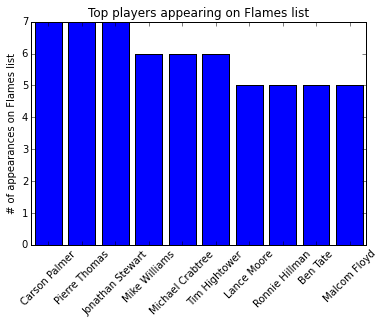

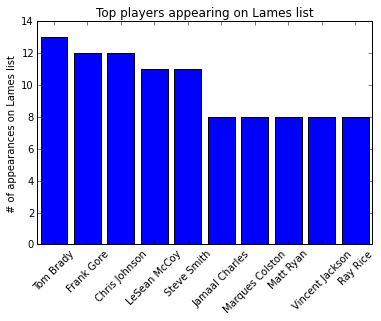

In [3]:
%matplotlib inline
from collections import Counter
from matplotlib import pyplot as plt


flames_lames = pickle.load(open("flames_lames.p", "rb"))

flames_players = []
lames_players = []

for key in flames_lames:
    if flames_lames[key]['flame_lame'] == 'flames':
        flames_players.append(flames_lames[key]['player_name'])
    if flames_lames[key]['flame_lame'] == 'lames':
        lames_players.append(flames_lames[key]['player_name'])

flames_players.sort()
lames_players.sort()

flames_player_name = []
flames_player_count = []

flames_count = Counter(flames_players)

for name, count in flames_count.most_common(10):
    flames_player_name.append(name)
    flames_player_count.append(count)
    
lames_player_name = []
lames_player_count = []
lames_count = Counter(lames_players)

for name, count in lames_count.most_common(10):
    lames_player_name.append(name)
    lames_player_count.append(count)

xs = [i + 0.1 for i, _ in enumerate(flames_player_name)]
plt.bar(xs, flames_player_count)
plt.ylabel('# of appearances on Flames list')
plt.title('Top players appearing on Flames list')
plt.xticks([i + 0.5 for i, _ in enumerate(flames_player_name)], flames_player_name)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

plt.show()

xs = [i + 0.1 for i, _ in enumerate(lames_player_name)]
plt.bar(xs, lames_player_count)
plt.ylabel('# of appearances on Lames list')
plt.title('Top players appearing on Lames list')
plt.xticks([i + 0.5 for i, _ in enumerate(lames_player_name)], lames_player_name)
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

plt.show()
    

Man, Brad hates Tom Brady. But really, who doesn't? And I've felt like he's always had it out for Chris Johnson (CJ2LAME if I remember correctly), but wasn't he kind of an easy target? At least after 2012 anyway. So that's kinda cool. What about players who appeared on both lists? Does Brad flipflop? 

Carson Palmer has 8 appearances
Darren Sproles has 8 appearances
Pierre Thomas has 9 appearances
LeSean McCoy has 13 appearances
Jamaal Charles has 10 appearances
Knowshon Moreno has 8 appearances
Chris Johnson has 13 appearances
Mike Williams has 8 appearances
Michael Crabtree has 8 appearances
Matt Ryan has 9 appearances
Rashard Mendenhall has 9 appearances
Ryan Mathews has 11 appearances
Steve Smith has 13 appearances
Philip Rivers has 9 appearances
Ben Roethlisberger has 9 appearances
Marshawn Lynch has 9 appearances


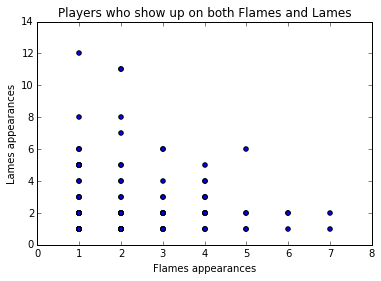

In [4]:
flames_and_lames = set(flames_players).intersection(lames_players)

flames_and_lames_flames_count = []
flames_and_lames_lames_count = []


total_count = 0
for name in flames_and_lames:
    total_count_player = 0
    for flame_name, count in flames_count.most_common():
        if flame_name == name:
            flames_and_lames_flames_count.append(count)
            total_count += count
            total_count_player += count
    for lame_name, count in lames_count.most_common():
        if lame_name == name:
            flames_and_lames_lames_count.append(count)
            total_count += count
            total_count_player += count
    if (total_count_player > 7):
        print(name + ' has ' + str(total_count_player) + ' appearances')

plt.scatter(flames_and_lames_flames_count, flames_and_lames_lames_count)

plt.title("Players who show up on both Flames and Lames")
plt.xlabel('Flames appearances')
plt.ylabel('Lames appearances')

plt.show()

Now it's probably time to grab some NFL data. I was expecting this to be next to impossible, in an automated fashion, but the NFL website is slightly more accommodating than I initially presumed. I've created this as a separate project over here: https://github.com/bdetweiler/nfl-database



In [64]:
from storm.locals import *
import csv
import re
from pprint import pprint
import os
import math

from os import listdir
from os.path import isfile, join
from os import walk

class Player(object):
    __storm_table__ = "PLAYER"
    PLAYER_ID = Int(primary=True)
    FIRST_NAME = Unicode()
    MIDDLE_NAME = Unicode()
    LAST_NAME = Unicode()
    NAME_SUFFIX = Unicode()
    HEIGHT = Float()
    WEIGHT = Float()
    BIRTH_DATE = Date()
    BIRTH_CITY = Unicode()
    BIRTH_STATE = Unicode()
    BIRTH_COUNTRY = Unicode()
    HIGH_SCHOOL_NAME = Unicode()
    HIGH_SCHOOL_CITY = Unicode()
    HIGH_SCHOOL_STATE = Unicode()
    COLLEGE = Unicode()
    
    def __init__(self, player_id, first_name, middle_name, last_name, name_suffix, height, weight, birth_date, birth_city, birth_state, birth_country, high_school_name, high_school_city, high_school_state, college):
        self.PLAYER_ID = int(player_id)
        self.FIRST_NAME = u'' + first_name
        self.MIDDLE_NAME = u'' + middle_name
        self.LAST_NAME = u'' + last_name
        self.NAME_SUFFIX = u'' + name_suffix
        self.HEIGHT = float(height)
        self.WEIGHT = float(weight)
        
        if (birth_date != ''):
            self.BIRTH_DATE = birth_date
            
        self.BIRTH_CITY = u'' + birth_city
        self.BIRTH_STATE = u'' + birth_state
        self.BIRTH_COUNTRY = u'' + birth_country
        self.HIGH_SCHOOL_NAME = u'' + high_school_name
        self.HIGH_SCHOOL_CITY = u'' + high_school_city
        self.HIGH_SCHOOL_STATE = u'' + high_school_state
        self.COLLEGE = u'' + college
        

    def __str__(self):
        return 'Player[ PLAYER_ID = ' + str(self.PLAYER_ID) + ', FIRST_NAME = ' + self.FIRST_NAME + ', MIDDLE_NAME = ' + self.MIDDLE_NAME + ', LAST_NAME = ' + self.LAST_NAME + ', NAME_SUFFIX = ' + self.NAME_SUFFIX + ', HEIGHT = ' + str(self.HEIGHT) + ', WEIGHT = ' + str(self.WEIGHT) + ', BIRTH_DATE = ' +  str(self.BIRTH_DATE) + ', BIRTH_CITY = ' + self.BIRTH_CITY + ', BIRTH_STATE = ' + self.BIRTH_STATE + ', BIRTH_COUNTRY = ' + self.BIRTH_COUNTRY + ', HIGH_SCHOOL_NAME = ' + self.HIGH_SCHOOL_NAME + ', HIGH_SCHOOL_CITY = ' + self.HIGH_SCHOOL_CITY + ', HIGH_SCHOOL_STATE = ' + self.HIGH_SCHOOL_STATE + ', COLLEGE = ' + self.COLLEGE + ' ]'

class Team(object):
    __storm_table__ = "TEAM"
    TEAM_ID = Unicode(primary=True)
    TEAM_ABBRV = Unicode()
    LONG_NAME = Unicode()
    CONFERENCE = Unicode()
    DIVISION = Unicode()
    def __init__(self, team_id, team_abbrv, long_name, conference, division):
        self.TEAM_ID = team_id
        self.TEAM_ABBRV = team_abbrv
        self.LONG_NAME = long_name
        self.CONFERENCE = conference
        self.DIVISION = division
    
    def verbose_team_name(team_name):
        if(team_name.lower() == 'Buccaneers') or (team_name.lower() == 'TB'):
            return 'Tampa Bay Buccaneers'
        if(team_name.lower() == 'Vikings') or (team_name.lower() == 'MIN'):
            return 'Minnesota Vikings'
        if(team_name.lower() == 'Jets') or (team_name.lower() == 'NYJ'):
            return 'New York Jets'
        if(team_name.lower() == 'Texans') or (team_name.lower() == 'HOU'):
            return 'Houston Texans'
        if(team_name.lower() == 'Bears') or (team_name.lower() == 'CHI'):
            return 'Chicago Bears'
        if(team_name.lower() == 'Cowboys') or (team_name.lower() == 'DAL'):
            return 'Dallas Cowboys'
        if(team_name.lower() == 'Buccaneers') or (team_name.lower() == 'TB'):
            return 'Tampa Bay Buccaneers'
        if(team_name.lower() == 'Buccaneers') or (team_name.lower() == 'TB'):
            return 'Tampa Bay Buccaneers'
        if(team_name.lower() == 'Bengals') or (team_name.lower() == 'CIN'):
            return 'Cincinnatti Bengals'
        if(team_name.lower() == '49ers') or (team_name.lower() == 'SF'):
            return 'San Francisco 49ers'
        if(team_name.lower() == 'Bills') or (team_name.lower() == 'BUF'):
            return 'Buffalo Bills'
        if(team_name.lower() == 'Broncos') or (team_name.lower() == 'DEN'):
            return 'Denver Broncos'
        if(team_name.lower() == 'Browns') or (team_name.lower() == 'CLE'):
            return 'Cleveland Browns'
        if(team_name.lower() == 'Cardinals') or (team_name.lower() == 'ARI'):
            return 'Arizona Cardinals'
        if(team_name.lower() == 'Chargers') or (team_name.lower() == 'SD'):
            return 'San Diego Chargers'
        if(team_name.lower() == 'Chiefs') or (team_name.lower() == 'KC'):
            return 'Kansas City Chiefs'
        if(team_name.lower() == 'Colts') or (team_name.lower() == 'IND'):
            return 'Indianapolis Colts'
        if(team_name.lower() == 'Dolphins') or (team_name.lower() == 'MIA'):
            return 'Miami Dolphins'
        if(team_name.lower() == 'Eagles') or (team_name.lower() == 'PHI'):
            return 'Philadelphia Eagles'
        if(team_name.lower() == 'Falcons') or (team_name.lower() == 'ATL'):
            return 'Atlanta Falcons'
        if(team_name.lower() == 'Giants') or (team_name.lower() == 'NYG'):
            return 'New York Giants'
        if(team_name.lower() == 'Jaguars') or (team_name.lower() == 'JAX'):
            return 'Jacksonville Jaguars'
        if(team_name.lower() == 'Lions') or (team_name.lower() == 'DET'):
            return 'Detroit Lions'
        if(team_name.lower() == 'Oilers') or (team_name.lower() == 'OIL'):
            return 'Houston Oilers'
        if(team_name.lower() == 'Packers') or (team_name.lower() == 'GB'):
            return 'Green Bay Packers'
        if(team_name.lower() == 'Panthers') or (team_name.lower() == 'CAR'):
            return 'Carolina Panthers'
        if(team_name.lower() == 'Patriots') or (team_name.lower() == 'NE'):
            return 'New England Patriots'
        if(team_name.lower() == 'Raiders') or (team_name.lower() == 'OAK'):
            return 'Oakland Raiders'
        if(team_name.lower() == 'Rams') or (team_name.lower() == 'STL'):
            return 'St. Louis Rams'
        if(team_name.lower() == 'Ravens') or (team_name.lower() == 'BAL'):
            return 'Baltimore Ravens'
        if(team_name.lower() == 'Redskins') or (team_name.lower() == 'WAS'):
            return 'Washington Redskins'
        if(team_name.lower() == 'Saints') or (team_name.lower() == 'NO'):
            return 'New Orleans Saints'
        if(team_name.lower() == 'Seahawks') or (team_name.lower() == 'SEA'):
            return 'Seattle Seahawks'
        if(team_name.lower() == 'Steelers') or (team_name.lower() == 'PIT'):
            return 'Pittsburgh Steelers'
        if(team_name.lower() == 'Titans') or (team_name.lower() == 'TEN'):
            return 'Tennessee Titans'
    def __str__(self):
        return 'Team[ TEAM_ID = ' + str(self.TEAM_ID) + ', Team_ABBRV = ' + self.TEAM_ABBRV + ', LONG_NAME = ' + self.LONG_NAME + ', CONFERENCE = ' + self.CONFERENCE + ', DIVISION = ' + self.DIVISION + ']'
    
    
class Game(object):
    __storm_table__ = "GAME"
    GAME_ID = Int(primary=True)
    SEASON = Unicode()
    YEAR = Int()
    WEEK_TMP = Int()
    HOME_TEAM = Unicode()
    VISITING_TEAM = Unicode()
    HOME_TEAM_SCORE = Int()
    VISITING_TEAM_SCORE = Int()
    HOME_TEAM_RESULT = Unicode()
    VISITING_TEAM_RESULT = Unicode()
    GAME_DATE = Date()
    DAY_OF_WEEK = Unicode()
    POST_SEASON_TYPE = Unicode()
    
    def __init__(self, game_id, season, year, week, home_team, visiting_team, home_team_score, visiting_team_score, home_team_result, visiting_team_result, game_date, day_of_week, post_season_type):

        self.GAME_ID = int(game_id)

        self.SEASON = u'' + season

        self.YEAR = int(year)

        # I screwed up and set week as a varchar, so we have to use week_tmp
        self.WEEK_TMP = week

        self.HOME_TEAM = u'' + home_team
        self.VISITING_TEAM = u'' + visiting_team
        
        if(isinstance(home_team_score, float) == False):
            home_team_score = float(home_team_score)
        if (math.isnan(home_team_score) == False):
            self.HOME_TEAM_SCORE = int(home_team_score)

        if(isinstance(visiting_team_score, float) == False):
            visiting_team_score = float(visiting_team_score)
        if (math.isnan(visiting_team_score) == False):
            self.VISITING_TEAM_SCORE = int(visiting_team_score)

        self.HOME_TEAM_RESULT = u'' + home_team_result
        self.VISITING_TEAM_RESULT = u'' + visiting_team_result
        
        if(game_date != ''):
            self.GAME_DATE = game_date

        self.DAY_OF_WEEK = u'' + day_of_week
        if (post_season_type != ''):
            self.POST_SEASON_TYPE = u'' + post_season_type

    def __str__(self):
        return 'Game[ GAME_ID = ' + str(self.GAME_ID) + ', SEASON = ' + str(self.SEASON) + ', YEAR = ' + str(self.YEAR) + ', WEEK_TMP = ' + str(self.WEEK_TMP) + ', HOME_TEAM = ' + str(self.HOME_TEAM) + ', AWAY_TEAM = ' + str(self.VISITING_TEAM) + ', HOME_TEAM_RESULT = ' + str(self.HOME_TEAM_RESULT) + ', VISITING_TEAM_RESULT = ' + str(self.VISITING_TEAM_RESULT) + ', GAME_DATE = ' + str(self.GAME_DATE) + ', DAY_OF_WEEK = ' + str(self.DAY_OF_WEEK) + ', POST_SEASON_TYPE = ' + str(self.POST_SEASON_TYPE) + ']'

        
class Roster(object):
    __storm_table__ = "ROSTER"
    ROSTER_ID = Int(primary=True)
    TEAM_ID = Unicode()
    GAME_ID = Int()
    game = Reference(GAME_ID, Game.GAME_ID)
    team = Reference(TEAM_ID, Team.TEAM_ID)
    
    def __init__(self, roster_id, team_id, game_id):
        self.ROSTER_ID = int(roster_id)
        self.TEAM_ID = u'' + team_id
        self.GAME_ID = int(game_id)
        
    def __str__(self):
        return 'Roster[ ROSTER_ID = ' + str(self.GAME_ID) + ', SEASON = ' + str(self.SEASON) + ', YEAR = ' + str(self.YEAR) + ', WEEK = ' + str(self.WEEK) + ', HOME_TEAM = ' + str(self.HOME_TEAM) + ', AWAY_TEAM = ' + str(self.VISITING_TEAM) + ', HOME_TEAM_RESULT = ' + str(self.HOME_TEAM_RESULT) + ', VISITING_TEAM_RESULT = ' + str(self.VISITING_TEAM_RESULT) + ', GAME_DATE = ' + str(self.GAME_DATE) + ', DAY_OF_WEEK = ' + str(self.DAY_OF_WEEK) + ', POST_SEASON_TYPE = ' + str(self.POST_SEASON_TYPE) + ']'        

class Stats(object):
    __storm_table__ = "PLAYER_STATS"
    
    PLAYER_STATS_ID = Int(primary=True) 
    PLAYER_ID = Int()
    ROSTER_ID = Int()
    GAME_PLAYED = Unicode()
    GAME_STARTED = Unicode()
    PASS_COMPLETED = Int()
    PASS_ATTEMPTED = Int()
    PASS_PERCENTAGE = Float()
    PASS_YARDS = Float()
    PASS_AVERAGE_YARDS = Float()
    PASS_TD = Int()
    PASS_INT = Int()
    PASS_SACK = Int()
    PASS_SACK_YARDS = Float()
    PASS_RATING   = Float()
    RUSH_ATTEMPTS = Int()
    RUSH_YARDS = Float()
    RUSH_AVERAGE = Float()
    RUSH_LONG = Float()
    RUSH_TD = Int()
    FUMBLES = Int()
    FUMBLES_LOST = Int()
    RECEIVING_RECEPTIONS = Int()
    RECEIVING_YARDS = Float()
    RECEIVING_AVERAGE = Float()
    RECEIVING_LONG = Float()
    RECEIVING_TD = Int()
    FG_BLOCKED = Int()
    FG_LONG = Float()
    FG_ATTEMPTS = Int()
    FG_MADE = Int()
    FG_PERCENT = Float()
    XP_MADE = Int()
    XP_ATTEMPTS = Int()
    XP_PERCENT = Float()
    XP_BLOCKED = Int()
    KICKOFFS = Int()
    KICKOFFS_AVERAGE = Float()
    KICKOFFS_TOUCHBACKS = Int()
    KICKOFFS_RETURNED = Int()
    KICKOFFS_AVERAGE = Float()
    RUSH_LONG_TD = Unicode()
    RECEIVING_LONG_TD = Unicode()
    KICKOFFS_RETURNED_AVERAGE = Float()

    player = Reference(PLAYER_ID, Player.PLAYER_ID)
    roster = Reference(ROSTER_ID, Roster.ROSTER_ID)
    
    def __init__(self, player_stats_id, player_id, roster_id, game_result, game_played, game_started, pass_completed, pass_attempted, pass_percentage, pass_yards, pass_average_yards, pass_td, pass_int, pass_sack, pass_sack_yards, pass_rating, rush_attempts, rush_yards, rush_average, rush_long, rush_td, fumbles, fumbles_lost, receiving_receptions, receiving_yards, receiving_average, receiving_long, receiving_td, fg_blocked, fg_long, fg_attempts, fg_made, fg_percent, xp_made, xp_attempts, xp_percent, xp_blocked, kickoffs, kickoffs_average, kickoffs_touchbacks, kickoffs_returned, rush_long_td, receiving_long_td, kickoffs_returned_average):
        self.PLAYER_STATS_ID = int(player_stats_id)
        self.PLAYER_ID = int(player_id)
        self.ROSTER_ID = int(roster_id)
        
        if (game_played is not None):
            self.GAME_PLAYED = u'' + game_played
        else:
            self.GAME_PLAYED = u''
            
        if (game_started is not None):
            self.GAME_STARTED = u'' + game_started
        else:
            self.GAME_STARTED = u''
        
        # Passing
        self.PASS_COMPLETED = int(pass_completed)
        self.PASS_ATTEMPTED = int(pass_attempted)
        self.PASS_PERCENTAGE = float(pass_percentage)
        self.PASS_YARDS = float(pass_yards)
        self.PASS_AVERAGE_YARDS = float(pass_average_yards)
        self.PASS_TD = int(pass_td)
        self.PASS_INT = int(pass_int)
        self.PASS_SACK = int(pass_sack)
        self.PASS_SACK_YARDS = float(pass_sack_yards)
        self.PASS_RATING = float(pass_rating)
        
        # Rushing
        self.RUSH_ATTEMPTS = int(rush_attempts)
        self.RUSH_YARDS = float(rush_yards)
        self.RUSH_AVERAGE = float(rush_average)
        self.RUSH_LONG = float(rush_long)
        if (rush_long_td is not None):
            self.RUSH_LONG_TD = u'' + rush_long_td
        else:
            self.RUSH_LONG_TD = u''
            
        self.RUSH_TD = int(rush_td)
        self.FUMBLES = int(fumbles)
        self.FUMBLES_LOST = int(fumbles_lost)
        
        # Receiving
        self.RECEIVING_RECEPTIONS = int(receiving_receptions)
        self.RECEIVING_YARDS = float(receiving_yards)
        self.RECEIVING_AVERAGE = float(receiving_average)
        self.RECEIVING_LONG = float(receiving_long)
        
        if (receiving_long_td is not None):
            self.RECEIVING_LONG_TD = u'' + receiving_long_td
        else:
            self.RECEIVING_LONG_TD = u''
            
        self.RECEIVING_TD = int(receiving_td)
        
        # Field Goals
        self.FG_BLOCKED = int(fg_blocked)
        self.FG_LONG = float(fg_long)
        self.FG_ATTEMPTS = int(fg_attempts)
        self.FG_MADE = int(fg_made)
        self.FG_PERCENT = float(fg_percent)
        
        # Extra Points
        self.XP_MADE = int(xp_made)
        self.XP_ATTEMPTS = int(xp_attempts)
        self.XP_PERCENT = float(xp_percent)
        self.XP_BLOCKED = int(xp_blocked)
        
        # Kickoffs
        self.KICKOFFS = int(kickoffs)
        self.KICKOFFS_AVERAGE = float(kickoffs_average)
        self.KICKOFFS_TOUCHBACKS = int(kickoffs_touchbacks)
        self.KICKOFFS_RETURNED = int(kickoffs_returned)
        self.KICKOFFS_RETURNED_AVERAGE = float(kickoffs_returned_average)

class FlamesLames(object):
    __storm_table__ = "FLAMES_LAMES"
    
    FLAMES_LAMES_ID = Int(primary=True)
    YEAR = Int()
    WEEK = Int()
    DATE_POSTED = Date()
    GAME_DATE = Date()
    FLAME_LAME = Unicode()
    PLAYER_FIRST_NAME = Unicode()
    PLAYER_MIDDLE_NAME = Unicode()
    PLAYER_LAST_NAME = Unicode()
    PLAYER_SUFFIX = Unicode()
    PLAYER_ID = Int()
    PLAYER_TEAM = Unicode()
    PLAYER_POSITION = Unicode()
    PLAYER_PERCENT_STARTED = Float()
    SHOCKER_SPECIAL_FLAG = Unicode()
    HOME_AWAY = Unicode()
    OPPONENT_TEAM = Unicode()
    BLURB = Unicode()
    
    ## Fearless Forecast
    FF_PASS_ATTEMPTED = Int()
    FF_PASS_COMPLETED = Int()
    FF_PASS_INT = Int()
    FF_PASS_YARDS = Float()
    FF_PASS_TD = Int()
    FF_RUSH_ATTEMPTS = Int()
    FF_RUSH_YARDS = Float()
    FF_RUSH_TD = Int()
    FF_FUMBLES_LOST = Int()
    FF_FUMBLES_RECOVERED = Int()
    FF_DEFENSE_INT = Int()
    FF_DEFENSE_POINTS_ALLOWED = Float()
    FF_DEFENSE_SACKS = Int()
    FF_RECEIVING_YARDS = Int()
    FF_RECEIVING_RECEPTIONS = Int()
    FF_TOTAL_YARDS = Float()
    ACT_FANTASY_POINTS = Float()
    FF_TOTAL_TD = Int()
    FF_TURNOVERS = Int()
    
    # Actual Stats
    ACT_GAME_PLAYED = Unicode()
    ACT_GAME_STARTED = Unicode()
    ACT_PASS_COMPLETED = Int()
    ACT_PASS_ATTEMPTED = Int()
    ACT_PASS_PERCENTAGE = Float()
    ACT_PASS_YARDS = Float()
    ACT_PASS_AVERAGE_YARDS = Float()
    ACT_PASS_TD = Int()
    ACT_PASS_INT = Int()
    ACT_PASS_SACK = Int()
    ACT_PASS_SACK_YARDS = Float()
    ACT_PASS_RATING   = Float()
    ACT_RUSH_ATTEMPTS = Int()
    ACT_RUSH_YARDS = Float()
    ACT_RUSH_AVERAGE = Float()
    ACT_RUSH_LONG = Float()
    ACT_RUSH_TD = Int()
    ACT_FUMBLES = Int()
    ACT_FUMBLES_LOST = Int()
    ACT_RECEIVING_RECEPTIONS = Int()
    ACT_RECEIVING_YARDS = Float()
    ACT_RECEIVING_AVERAGE = Float()
    ACT_RECEIVING_LONG = Float()
    ACT_RECEIVING_TD = Int()
    ACT_FG_BLOCKED = Int()
    ACT_FG_LONG = Float()
    ACT_FG_ATTEMPTS = Int()
    ACT_FG_MADE = Int()
    ACT_FG_PERCENT = Float()
    ACT_XP_MADE = Int()
    ACT_XP_ATTEMPTS = Int()
    ACT_XP_PERCENT = Float()
    ACT_XP_BLOCKED = Int()
    ACT_KICKOFFS = Int()
    ACT_KICKOFFS_AVERAGE = Float()
    ACT_KICKOFFS_TOUCHBACKS = Int()
    ACT_KICKOFFS_RETURNED = Int()
    ACT_RUSH_LONG_TD = Unicode()
    ACT_RECEIVING_LONG_TD = Unicode()
    ACT_KICKOFFS_RETURNED_AVERAGE = Float()

    # Man this thing is long...
    def __init__(self, flames_lames_id, year, week, date_posted, game_date, flame_lame, player_first_name, player_middle_name, player_last_name, player_suffix, player_id, player_team, player_position, player_percent_started, shocker_special_flag, home_away, opponent_team, blurb, ff_pass_attempted, ff_pass_completed, ff_pass_int, ff_pass_yards, ff_pass_td, ff_rush_attempts, ff_rush_yards, ff_rush_td, ff_fumbles_lost, ff_fumbles_recovered, ff_defense_int, ff_defense_points_allowed, ff_defense_sacks, ff_receiving_yards, ff_receiving_receptions, ff_total_yards, act_fantasy_points, ff_total_td, ff_turnovers, act_game_played, act_game_started, act_pass_completed, act_pass_attempted, act_pass_percentage, act_pass_yards, act_pass_average_yards, act_pass_td, act_pass_int, act_pass_sack, act_pass_sack_yards, act_pass_rating  , act_rush_attempts, act_rush_yards, act_rush_average, act_rush_long, act_rush_td, act_fumbles, act_fumbles_lost, act_receiving_receptions, act_receiving_yards, act_receiving_average, act_receiving_long, act_receiving_td, act_fg_blocked, act_fg_long, act_fg_attempts, act_fg_made, act_fg_percent, act_xp_made, act_xp_attempts, act_xp_percent, act_xp_blocked, act_kickoffs, act_kickoffs_touchbacks, act_kickoffs_returned, act_kickoffs_average, act_rush_long_td, act_receiving_long_td, act_kickoffs_returned_average):
         
        self.FLAMES_LAMES_ID = int(flames_lames_id)
        self.YEAR = int(year)
        self.WEEK = int(week)
        
        if(date_posted != ''):
            self.DATE_POSTED = date_posted
            
        if(game_date != ''):
            self.GAME_DATE = game_date
            
        if (flame_lame is not None):
            self.FLAME_LAME = u'' + flame_lame
        else:
            self.FLAME_LAME = u''
            
        if (player_first_name is not None):
            self.PLAYER_FIRST_NAME = u'' + player_first_name
        else:
            self.PLAYER_FIRST_NAME = u''
            
        if (player_middle_name is not None):    
            self.PLAYER_MIDDLE_NAME = u'' + player_middle_name
        else:
            self.PLAYER_MIDDLE_NAME = u''
            
        if (player_last_name is not None):
            self.PLAYER_LAST_NAME = u'' + player_last_name
        else:
            self.PLAYER_LAST_NAME = u''
            
        if (player_suffix is not None):
            self.PLAYER_SUFFIX = u'' + player_suffix
        else: 
            self.PLAYER_SUFFIX = u''
            
        
        self.PLAYER_ID = int(player_id)
        
        if (player_team is not None):
            self.PLAYER_TEAM = u'' + player_team
        else:
            self.PLAYER_TEAM = u''
            
        if (player_position is not None):
            self.PLAYER_POSITION = u'' + player_position
        else:
            self.PLAYER_POSITION = u''

        self.PLAYER_PERCENT_STARTED = float(player_percent_started)
        
        if (shocker_special_flag is not None):
            self.SHOCKER_SPECIAL_FLAG = u'' + shocker_special_flag
        else:
            self.SHOCKER_SPECIAL_FLAG = u''
            
        if (home_away is not None):
            self.HOME_AWAY = u'' + home_away
        else:
            self.HOME_AWAY = u''
            
        if (opponent_team is not None):
            self.OPPONENT_TEAM = u'' + opponent_team
        else:
            self.OPPONENT_TEAM = u''
            
        if (blurb is not None):
            self.BLURB = u'' + blurb
        else:
            self.BLURB = u''
        
        # Fearless Forecast
        if (math.isnan(float(ff_pass_attempted))):
            self.FF_PASS_ATTEMPTED = int(0)
        else:
            self.FF_PASS_ATTEMPTED = int(ff_pass_attempted)
        
        if (math.isnan(float(ff_pass_completed))):
            self.FF_PASS_COMPLETED = int(0)
        else:
            self.FF_PASS_COMPLETED = int(ff_pass_completed)
            
        if (math.isnan(float(ff_pass_int))):
            self.FF_PASS_INT = int(0)
        else:
            self.FF_PASS_INT = int(ff_pass_int)
        
        if (math.isnan(float(ff_pass_yards))):
            self.FF_PASS_YARDS = float(0)
        else:
            self.FF_PASS_YARDS = float(ff_pass_yards)
            
        if (math.isnan(float(ff_pass_td))):
            self.FF_PASS_TD = int(0)
        else:
            self.FF_PASS_TD = int(ff_pass_td)
        
        if (math.isnan(float(ff_rush_attempts))):
            self.FF_RUSH_ATTEMPTS = int(0)
        else:
            self.FF_RUSH_ATTEMPTS = int(ff_rush_attempts)
        
        if (math.isnan(float(ff_rush_yards))):
            self.FF_RUSH_YARDS = float(0)
        else:
            self.FF_RUSH_YARDS = float(ff_rush_yards)
            
        if (math.isnan(float(ff_rush_td))):
            self.FF_RUSH_TD = int(0)
        else:
            self.FF_RUSH_TD = int(ff_rush_td)
        
        if (math.isnan(float(ff_fumbles_lost))):
            self.FF_FUMBLES_LOST = int(0)
        else:
            self.FF_FUMBLES_LOST = int(ff_fumbles_lost)
            
        if (math.isnan(float(ff_fumbles_recovered))):    
            self.FF_FUMBLES_RECOVERED = int(0)
        else:
            self.FF_FUMBLES_RECOVERED = int(ff_fumbles_recovered)
        
        if (math.isnan(float(ff_defense_int))):    
            self.FF_DEFENSE_INT = int(0)
        else:
            self.FF_DEFENSE_INT = int(ff_defense_int)
        
        if (math.isnan(float(ff_defense_points_allowed))):    
            self.FF_DEFENSE_POINTS_ALLOWED = float(0)
        else:
            self.FF_DEFENSE_POINTS_ALLOWED = float(ff_defense_points_allowed)
        
        if (math.isnan(float(ff_defense_sacks))):    
            self.FF_DEFENSE_SACKS = float(0)
        else:
            self.FF_DEFENSE_SACKS = float(ff_defense_sacks)
            
        if (math.isnan(float(ff_receiving_yards))):    
            self.FF_RECEIVING_YARDS = float(0)
        else:
            self.FF_RECEIVING_YARDS = float(ff_receiving_yards)
        
        if (math.isnan(float(ff_receiving_receptions))):    
            self.FF_RECEIVING_RECEPTIONS = int(0)
        else:
            self.FF_RECEIVING_RECEPTIONS = int(ff_receiving_receptions)
            
        if (math.isnan(float(ff_total_yards))):
            self.FF_TOTAL_YARDS = float(0)
        else:
            self.FF_TOTAL_YARDS = float(ff_total_yards)
            
        if (math.isnan(float(act_fantasy_points))):
            self.ACT_FANTASY_POINTS = float(0)
        else:
            self.ACT_FANTASY_POINTS = float(act_fantasy_points)
            
        if (math.isnan(float(ff_total_td))):
            self.FF_TOTAL_TD = int(0)
        else:
            self.FF_TOTAL_TD = int(ff_total_td)
            
        if (math.isnan(float(ff_turnovers))):
            self.FF_TURNOVERS = int(0)
        else:
            self.FF_TURNOVERS = int(ff_turnovers)
        
        # Actual Stats
        
        if (act_game_played is not None):
            self.ACT_GAME_PLAYED = u'' + act_game_played
        else:
            self.ACT_GAME_PLAYED = u''
            
        if (act_game_started is not None):
            self.ACT_GAME_STARTED = u'' + act_game_started
        else:
            self.ACT_GAME_STARTED = u''
            
        if (math.isnan(float(act_pass_completed))):
            self.ACT_PASS_COMPLETED = int(0)            
        else:
            self.ACT_PASS_COMPLETED = int(act_pass_completed)

        if (math.isnan(float(act_pass_attempted))):
            self.ACT_PASS_ATTEMPTED = int(0)
        else:
            self.ACT_PASS_ATTEMPTED = int(act_pass_attempted)
            
        if (math.isnan(float(act_pass_percentage))):
            self.ACT_PASS_PERCENTAGE = float(act_pass_percentage)
        else:
            self.ACT_PASS_PERCENTAGE = float(act_pass_percentage)
            
        if (math.isnan(float(act_pass_yards))):
            self.ACT_PASS_YARDS = float(0)
        else:
            self.ACT_PASS_YARDS = float(act_pass_yards)
            
        if (math.isnan(float(act_pass_average_yards))):
            self.ACT_PASS_AVERAGE_YARDS = float(0)
        else:
            self.ACT_PASS_AVERAGE_YARDS = float(act_pass_average_yards)
        
        if (math.isnan(float(act_pass_td))):
            self.ACT_PASS_TD = int(0)
        else:
            self.ACT_PASS_TD = int(act_pass_td)
        
        if (math.isnan(float(act_pass_int))):
            self.ACT_PASS_INT = int(0)
        else:
            self.ACT_PASS_INT = int(act_pass_int)
        
        if (math.isnan(float(act_pass_sack))):
            self.ACT_PASS_SACK = int(0)
        else:
            self.ACT_PASS_SACK = int(act_pass_sack)
        
        if (math.isnan(float(act_pass_sack_yards))):
            self.ACT_PASS_SACK_YARDS = float(0)
        else:
            self.ACT_PASS_SACK_YARDS = float(act_pass_sack_yards)
        
        if (math.isnan(float(act_pass_rating))):
            self.ACT_PASS_RATING   = float(0)
        else:
            self.ACT_PASS_RATING   = float(act_pass_rating)
        
        if (math.isnan(float(act_rush_attempts))):
            self.ACT_RUSH_ATTEMPTS = int(0)
        else:
            self.ACT_RUSH_ATTEMPTS = int(act_rush_attempts)
        
        if (math.isnan(float(act_rush_yards))):
            self.ACT_RUSH_YARDS = float(0)
        else:
            self.ACT_RUSH_YARDS = float(act_rush_yards)
        
        if (math.isnan(float(act_rush_average))):
            self.ACT_RUSH_AVERAGE = float(0)
        else:
            self.ACT_RUSH_AVERAGE = float(act_rush_average)
        
        if (math.isnan(float(act_rush_long))):
            self.ACT_RUSH_LONG = float(0)
        else:
            self.ACT_RUSH_LONG = float(act_rush_long)
        
        if (math.isnan(float(act_rush_td))):
            self.ACT_RUSH_TD = int(0)
        else:
            self.ACT_RUSH_TD = int(act_rush_td)
        
        if (math.isnan(float(act_fumbles))):
            self.ACT_FUMBLES = int(0)
        else:
            self.ACT_FUMBLES = int(act_fumbles)
        
        if (math.isnan(float(act_fumbles_lost))):
            self.ACT_FUMBLES_LOST = int(0)
        else:
            self.ACT_FUMBLES_LOST = int(act_fumbles_lost)
        
        if (math.isnan(float(act_receiving_receptions))):
            self.ACT_RECEIVING_RECEPTIONS = int(0)
        else:
            self.ACT_RECEIVING_RECEPTIONS = int(act_receiving_receptions)
        
        if (math.isnan(float(act_receiving_yards))):
            self.ACT_RECEIVING_YARDS = float(0)
        else:
            self.ACT_RECEIVING_YARDS = float(act_receiving_yards)

        if (math.isnan(float(act_receiving_average))):
            self.ACT_RECEIVING_AVERAGE = float(0)
        else:
            self.ACT_RECEIVING_AVERAGE = float(act_receiving_average)
        
        if (math.isnan(float(act_receiving_long))):
            self.ACT_RECEIVING_LONG = float(0)
        else:
            self.ACT_RECEIVING_LONG = float(act_receiving_long)
        
        if (math.isnan(float(act_receiving_td))):
            self.ACT_RECEIVING_TD = int(0)
        else:
            self.ACT_RECEIVING_TD = int(act_receiving_td)
        
        if (math.isnan(float(act_fg_blocked))):
            self.ACT_FG_BLOCKED = int(0)
        else:
            self.ACT_FG_BLOCKED = int(act_fg_blocked)
        
        if (math.isnan(float(act_fg_long))):
            self.ACT_FG_LONG = float(0)
        else:
            self.ACT_FG_LONG = float(act_fg_long)
        
        if (math.isnan(float(act_fg_attempts))):
            self.ACT_FG_ATTEMPTS = int(0)
        else:
            self.ACT_FG_ATTEMPTS = int(act_fg_attempts)
        
        if (math.isnan(float(act_fg_made))):
            self.ACT_FG_MADE = int(0)
        else:
            self.ACT_FG_MADE = int(act_fg_made)
            
        if (math.isnan(float(act_fg_percent))):
            self.ACT_FG_PERCENT = float(0)
        else:
            self.ACT_FG_PERCENT = float(act_fg_percent)
        
        if (math.isnan(float(act_xp_made))):
            self.ACT_XP_MADE = int(0)
        else:
            self.ACT_XP_MADE = int(act_xp_made)
        
        if (math.isnan(float(act_xp_attempts))):
            self.ACT_XP_ATTEMPTS = int(0)
        else:
            self.ACT_XP_ATTEMPTS = int(act_xp_attempts)
        
        if (math.isnan(float(act_xp_percent))):
            self.ACT_XP_PERCENT = float(0)
        else:
            self.ACT_XP_PERCENT = float(act_xp_percent)

        if (math.isnan(float(act_xp_blocked))):
            self.ACT_XP_BLOCKED = int(0)
        else:
            self.ACT_XP_BLOCKED = int(act_xp_blocked)
        
        if (math.isnan(float(act_kickoffs))):
            self.ACT_KICKOFFS = int(0)
        else:
            self.ACT_KICKOFFS = int(act_kickoffs)
        
        if (math.isnan(float(act_kickoffs_average))):
            self.ACT_KICKOFFS_AVERAGE = float(0)
        else:
            self.ACT_KICKOFFS_AVERAGE = float(act_kickoffs_average)
        
        if (math.isnan(float(act_kickoffs_touchbacks))):
            self.ACT_KICKOFFS_TOUCHBACKS = int(0)
        else:
            self.ACT_KICKOFFS_TOUCHBACKS = int(act_kickoffs_touchbacks)
        
        if (math.isnan(float(act_kickoffs_returned))):
            self.ACT_KICKOFFS_RETURNED = int(0)
        else:
            self.ACT_KICKOFFS_RETURNED = int(act_kickoffs_returned)
        
        if (act_rush_long_td is not None):
            self.ACT_RUSH_LONG_TD = u'' + act_rush_long_td
        else:
            self.ACT_RUSH_LONG_TD = u''
            
        if (act_receiving_long_td is not None):
            self.ACT_RECEIVING_LONG_TD = u'' + act_receiving_long_td
        else:
            self.ACT_RECEIVING_LONG_TD = u''
        
        if (act_kickoffs_returned_average is None or math.isnan(float(act_kickoffs_returned_average))):
            self.ACT_KICKOFFS_RETURNED_AVERAGE = float(0)
        else:
            self.ACT_KICKOFFS_RETURNED_AVERAGE = float(act_kickoffs_returned_average)
        
        def __str__(self):
            return 'FlamesLames[FLAMES_LAMES_ID = ' + str(flames_lames_id) + ', YEAR = ' + str(year) + ', WEEK = ' + str(week) + ', DATE_POSTED = ' + str(date_posted) + ', GAME_DATE = ' + str(game_date) + ', FLAME_LAME = ' + str(flame_lame) + ', PLAYER_FIRST_NAME = ' + player_first_name + ' PLAYER_MIDDLE_NAME = ' + player_middle_name + ', PLAYER_LAST_NAME = ' + player_last_name + ', PLAYER_SUFFIX = ' + player_suffix + ', PLAYER_ID = ' + str(player_id) + ', PLAYER_TEAM = ' + player_team + ', PLAYER_POSITION = ' + player_position + ', PLAYER_PERCENT_STARTED = ' + player_percent_started + ', SHOCKER_SPECIAL_FLAG = ' + shocker_special_flag + ' FF_PASS_ATTEMPTED = ' + str(ff_pass_attempted) + ' FF_PASS_COMPLETED = ' + str(ff_pass_completed) + ' FF_PASS_INT = ' + str(ff_pass_int) + ' FF_PASS_YARDS = ' + str(ff_pass_yards) + ' FF_PASS_TD = ' + str(ff_pass_td) + ' FF_RUSH_ATTEMPTS = ' + str(ff_rush_attempts) + ' FF_RUSH_YARDS = ' + str(ff_rush_yards) + ' FF_RUSH_TD = ' + str(ff_rush_td) + ' FF_FUMBLES_LOST = ' + str(ff_fumbles_lost) + ' FF_FUMBLES_RECOVERED = ' + str(ff_fumbles_recovered) + ' FF_DEFENSE_INT = ' + str(ff_defense_int) + ' FF_DEFENSE_POINTS_ALLOWED = ' + str(ff_defense_points_allowed) + ' FF_DEFENSE_SACKS = ' + str(ff_defense_sacks) + ' FF_RECEIVING_YARDS = ' + str(ff_receiving_yards) + ' FF_RECEIVING_RECEPTIONS = ' + str(ff_receiving_receptions) + ' FF_TOTAL_YARDS = ' + str(ff_total_yards) + ' ACT_FANTASY_POINTS = ' + str(act_fantasy_points) + ' FF_TOTAL_TD = ' + str(ff_total_td) + ' FF_TURNOVERS = ' + str(ff_turnovers) + ' ACT_GAME_PLAYED = ' + str(act_game_played) + ' ACT_GAME_STARTED = ' + str(act_game_started) + ' ACT_PASS_COMPLETED = ' + str(act_pass_completed) + ' ACT_PASS_ATTEMPTED = ' + str(act_pass_attempted) + ' ACT_PASS_PERCENTAGE = ' + str(act_pass_percentage) + ' ACT_PASS_YARDS = ' + str(act_pass_yards) + ' ACT_PASS_AVERAGE_YARDS = ' + str(act_pass_average_yards) + ' ACT_PASS_TD = ' + str(act_pass_td) + ' ACT_PASS_INT = ' + str(act_pass_int) + ' ACT_PASS_SACK = ' + str(act_pass_sack) + ' ACT_PASS_SACK_YARDS = ' + str(act_pass_sack_yards) + ' ACT_PASS_RATING   = ' + str(act_pass_rating) + ' ACT_RUSH_ATTEMPTS = ' + str(act_rush_attempts) + ' ACT_RUSH_YARDS = ' + str(act_rush_yards) + ' ACT_RUSH_AVERAGE = ' + str(act_rush_average) + ' ACT_RUSH_LONG = ' + str(act_rush_long) + ' ACT_RUSH_TD = ' + str(act_rush_td) + ' ACT_FUMBLES = ' + str(act_fumbles) + ' ACT_FUMBLES_LOST = ' + str(act_fumbles_lost) + ' ACT_RECEIVING_RECEPTIONS = ' + str(act_receiving_receptions) + ' ACT_RECEIVING_YARDS = ' + str(act_receiving_yards) + ' ACT_RECEIVING_AVERAGE = ' + str(act_receiving_average) + ' ACT_RECEIVING_LONG = ' + str(act_receiving_long) + ' ACT_RECEIVING_TD = ' + str(act_receiving_td) + ' ACT_FG_BLOCKED = ' + str(act_fg_blocked) + ' ACT_FG_LONG = ' + str(act_fg_long) + ' ACT_FG_ATTEMPTS = ' + str(act_fg_attempts) + ' ACT_FG_MADE = ' + str(act_fg_made) + ' ACT_FG_PERCENT = ' + str(act_fg_percent) + ' ACT_XP_MADE = ' + str(act_xp_made) + ' ACT_XP_ATTEMPTS = ' + str(act_xp_attempts) + ' ACT_XP_PERCENT = ' + str(act_xp_percent) + ' ACT_XP_BLOCKED = ' + str(act_xp_blocked) + ' ACT_KICKOFFS = ' + str(act_kickoffs) + ' ACT_KICKOFFS_AVERAGE = ' + str(act_kickoffs_average) + ' ACT_KICKOFFS_TOUCHBACKS = ' + str(act_kickoffs_touchbacks) + ' ACT_KICKOFFS_RETURNED = ' + str(act_kickoffs_returned) + ' ACT_KICKOFFS_AVERAGE = ' + str(act_kickoffs_average) + ' ACT_RUSH_LONG_TD = ' + str(act_rush_long_td) + ' ACT_RECEIVING_LONG_TD = ' + str(act_receiving_long_td) + ' ACT_KICKOFFS_RETURNED_AVERAGE = ' + str(act_kickoffs_returned_average) + ']'; 


In [68]:
%matplotlib inline
import datetime
from dateutil.parser import parse
from collections import Counter
from matplotlib import pyplot as plt
import pprint
import re
from pprint import pprint
import os

from os import listdir
from os.path import isfile, join
from os import walk

import pickle

mypath = '/home/bdetweiler/src/Data Science/Brad Evans Raw Data/NFL/players/'


nfl_database = create_database("sqlite:/home/bdetweiler/src/Data Science/brad-evans-analysis/nfl-database/nfl.db")
nfl_store = Store(nfl_database)

flames_lames_database = create_database("sqlite:/home/bdetweiler/src/Data Science/brad-evans-analysis/db/flames_lames.db")
flames_lames_store = Store(flames_lames_database)

flames_lames = pickle.load(open("flames_lames.p", "rb"))

flames_lames_id = 0

for key in flames_lames:
        
    flames_lames_id += 1
    
    year = int(flames_lames[key]['year'])
    week = int(flames_lames[key]['week'])
    
    # TODO
    date_posted = datetime.datetime.strptime(flames_lames[key]['date_posted'], "%Y-%m-%d")
    
    flame_lame = u'' + flames_lames[key]['flame_lame']
      
    player_name = flames_lames[key]['player_name']
    player_team = flames_lames[key]['player_team']
    home = flames_lames[key]['home']
    away = flames_lames[key]['away']
    player_position = flames_lames[key]['player_position']
    
    # XXX: Might have left this out
    # player_percent_started = flames_lames[key]['percent_started']
    
    shocker_special_flag = 'F'
    if (flames_lames[key]['shocker_special']):
        shocker_special_flag = 'T'
    
    blurb = flames_lames[key]['blurb'].decode('utf-8', 'ignore')
    opponent_team = flames_lames[key]['opponent']
    
    ff_pass_completed = flames_lames[key]['completions']
    ff_pass_int = flames_lames[key]['interceptions']
    ff_pass_attempted = flames_lames[key]['attempts']
    ff_pass_yards = flames_lames[key]['passing_yards']
    ff_pass_td = flames_lames[key]['passing_touchdowns']
    ff_rush_attempts = flames_lames[key]['carries']
    ff_rush_yards = flames_lames[key]['rushing_yards']    
    ff_rush_td = flames_lames[key]['rushing_touchdowns']
    ff_fumbles_lost = flames_lames[key]['fumbles_lost']
    ff_fumbles_recovered = flames_lames[key]['fumbles_recovered']
    ff_defense_int = flames_lames[key]['defensive_interceptions']
    ff_defense_points_allowed = flames_lames[key]['points_allowed']    
    ff_defense_sacks = flames_lames[key]['sacks']
    ff_receiving_yards = flames_lames[key]['receiving_yards']
    ff_receiving_receptions = flames_lames[key]['receptions']    
    ff_total_yards = flames_lames[key]['total_yards']
    ff_turnovers = flames_lames[key]['turnovers']
    ff_total_td = flames_lames[key]['total_touchdowns']     
    

    

    
    player_percent_started = flames_lames[key]['player_percent_started']

    
    m = re.match("([A-Za-z.'-]+) ([A-Za-z.'-]+).*", player_name)
    if m is not None:
        player_first_name = u'' + m.group(1)            
        player_last_name = u'' + m.group(2)
    
    player_rs = nfl_store.find(Player, And(Player.FIRST_NAME == player_first_name, Player.LAST_NAME == player_last_name))
    
    
    
    for p in player_rs:
        # Some players have the same name, but we know which one Brad is talking about
        if(player_rs.count() > 1):
            # Steve Smith
            if(p.PLAYER_ID == 2504595):
                player = p
                break
            # Adrian Peterson
            if(p.PLAYER_ID == 2507164):
                player = p
                break
            # Ryan Grant
            elif(p.PLAYER_ID == 2506140):
                player = p
                break
            # Alex Smith
            elif(p.PLAYER_ID == 2506340):
                player = p
                break
            # Mike Williams
            elif(p.PLAYER_ID == 2508048):
                player = p
                break
        else:
            player = p
    
    player_middle_name = player.MIDDLE_NAME
    player_suffix = player.NAME_SUFFIX
    player_id = player.PLAYER_ID
    
    print(player)
    print(player_team)
    #player_id, player_team, player_position, player_percent_started, shocker_special_flag, pass_attempted, pass_completed, pass_percentage, pass_int, pass_yards, pass_td, pass_sacks, rush_attempts, rush_yards, rush_td, fumbles_lost, fumbles_recovered, defense_int, defense_points_allowed, defense_sacks, receiving_yards, receiving_receptions, total_yards, fantasy_points, total_td, turnovers, home_away, opponent_team, blurb        
    team = nfl_store.find(Team, Team.TEAM_ABBRV == u'' + player_team.upper()).one()
    team_id = team.TEAM_ID
    
    
    print('year: ' + str(year) + ', week: ' + str(week) + ', team_id = ' + team_id)
    game = nfl_store.find(Game, And(Game.YEAR == year, Game.WEEK_TMP == week, Game.SEASON == u'REG', Or(Game.HOME_TEAM == u'' + team_id, Game.VISITING_TEAM == u'' + team_id))).one()

    if (game.HOME_TEAM == team_id):
        home = True
        away = False
        home_away = 'Home'
    else:
        home = False
        away = True
        home_away = 'Away'
        
    game_date = game.GAME_DATE
    
    roster = nfl_store.find(Roster, And(Roster.TEAM_ID == team_id, Roster.GAME_ID == game.GAME_ID)).one()
    
    print(str(player.PLAYER_ID) + ', ' +  str(roster.ROSTER_ID))
    stats_rs = nfl_store.find(Stats, And(Stats.PLAYER_ID == player.PLAYER_ID, Stats.ROSTER_ID == roster.ROSTER_ID))
    
    # Got some duplicates in the player_stats table. :/
    for stats in stats_rs:
        player_stats = stats
        break;
    
    print(stats)
    
    # Actual stats from the player_stats table
    act_game_played = stats.GAME_PLAYED
    act_game_started = stats.GAME_STARTED
    act_pass_completed = stats.PASS_COMPLETED
    act_pass_attempted = stats.PASS_ATTEMPTED
    act_pass_percentage = stats.PASS_PERCENTAGE
    act_pass_yards = stats.PASS_YARDS
    act_pass_average_yards = stats.PASS_AVERAGE_YARDS
    act_pass_td = stats.PASS_TD
    act_pass_int = stats.PASS_INT
    act_pass_sack = stats.PASS_SACK
    act_pass_sack_yards = stats.PASS_SACK_YARDS
    act_pass_rating = stats.PASS_RATING
    act_rush_attempts = stats.RUSH_ATTEMPTS
    act_rush_yards = stats.RUSH_YARDS
    act_rush_average = stats.RUSH_AVERAGE
    act_rush_long = stats.RUSH_LONG
    act_rush_td = stats.RUSH_TD
    act_fumbles = stats.FUMBLES
    act_fumbles_lost = stats.FUMBLES_LOST
    act_receiving_receptions = stats.RECEIVING_RECEPTIONS
    act_receiving_yards = stats.RECEIVING_YARDS
    act_receiving_average = stats.RECEIVING_AVERAGE
    act_receiving_long = stats.RECEIVING_LONG
    act_receiving_td = stats.RECEIVING_TD
    act_fg_blocked = stats.FG_BLOCKED
    act_fg_long = stats.FG_LONG
    act_fg_attempts = stats.FG_ATTEMPTS
    act_fg_made = stats.FG_MADE
    act_fg_percent = stats.FG_PERCENT
    act_xp_made = stats.XP_MADE
    act_xp_attempts = stats.XP_ATTEMPTS
    act_xp_percent = stats.XP_PERCENT
    act_xp_blocked = stats.XP_BLOCKED
    act_kickoffs = stats.KICKOFFS
    act_kickoffs_touchbacks = stats.KICKOFFS_TOUCHBACKS
    act_kickoffs_returned = stats.KICKOFFS_RETURNED
    act_kickoffs_average = stats.KICKOFFS_AVERAGE
    act_rush_long_td = stats.RUSH_LONG_TD
    act_receiving_long_td = stats.RECEIVING_LONG_TD
    act_kickoffs_returned_average = stats.KICKOFFS_RETURNED_AVERAGE
    
    # Based on standard Yahoo! scoring https://help.yahoo.com/kb/SLN6489.html
    act_fantasy_points = float(0)
    
    # Offensive statistics and scoring points
    
    # Every 25 passing yards:	1 point
    act_fantasy_points += float(act_pass_yards) / 25.0
    
    # Each passing TD:	4 points
    act_fantasy_points += float(act_pass_td) * 4.0
    
    # Each interception thrown:	-1 points
    act_fantasy_points += float(act_pass_int) * -1.0
    
    # Every 10 rushing yards:	1 point
    act_fantasy_points += float(act_rush_yards) / 10.0

    # Each rushing TD:	6 points
    act_fantasy_points += float(act_rush_td) / 6.0
    
    # Every 10 receiving yards:	1 point
    act_fantasy_points += float(act_receiving_yards) / 10.0

    # Each receiving TD:	6 points
    act_fantasy_points += float(act_receiving_td) * 6
    
    # XXX: NFL.com doesn't list this!!! Ugghh, should have went with ESPN.
    # Each return TD:	6 points

    # XXX: I don't have defensive players on here yet
    # Each Off Fum Ret TD:	6 points
    

    # XXX: I think NFL.com counts this as a TD. UGGGHHHH
    # Each 2-point conversion:	2 points
    
    # Each fumble lost:	-2 points
    act_fantasy_points += float(act_fumbles_lost) * -2.0
    
    # "Kicker Schmicker" as Brad would say
    # Kicking statistics and scoring points
    # Field goal 0-19 yards:	3 points
    # Field goal 20-29 yards:	3 points
    # Field goal 30-39 yards:	3 points
    # Field goal 40-49 yards:	4 points
    # Field goal 50+ yards:	5 points
    # Each extra point:	1 point
    
    # Defensive statistics and scoring points
    # Each sack:	1 point
    # act_fantasy_points += float(act_defensive_sack) * 1.0

    
    # Brad only did 2 defenses on Flames/Lames, and I don't have defense stats.
    # Might end up putting these in by hand...
    
    # Each interception:	2 points
    # act_fantasy_points += float(act_defensive_int) * 2.0
    # Each fumble recovery:	2 points
    # act_fantasy_points += float(act_defensive_fumbles_recovered) * 2.0
    # Each touchdown:	6 points
    # Each safety:	2 points
    # Each blocked kick:	2 points
    # Kickoff and Punt Return Touchdowns:	6 points
    # Shutout:	10 points
    # 1-6 points allowed:	7 points
    # 7-13 points allowed:	4 points
    # 14-20 points allowed:	1 point
    # 21-27 points allowed:	0 points
    # 28-34 points allowed:	-1 points
    # 35+ points allowed:	-4 points
    
    
    flames_lames_row = FlamesLames(flames_lames_id, year, week, date_posted, game_date, flame_lame, player_first_name, player_middle_name, player_last_name, player_suffix, player_id, player_team, player_position, player_percent_started, shocker_special_flag, home_away, opponent_team, blurb, ff_pass_attempted, ff_pass_completed, ff_pass_int, ff_pass_yards, ff_pass_td, ff_rush_attempts, ff_rush_yards, ff_rush_td, ff_fumbles_lost, ff_fumbles_recovered, ff_defense_int, ff_defense_points_allowed, ff_defense_sacks, ff_receiving_yards, ff_receiving_receptions, ff_total_yards, act_fantasy_points, ff_total_td, ff_turnovers, act_game_played, act_game_started, act_pass_completed, act_pass_attempted, act_pass_percentage, act_pass_yards, act_pass_average_yards, act_pass_td, act_pass_int, act_pass_sack, act_pass_sack_yards, act_pass_rating  , act_rush_attempts, act_rush_yards, act_rush_average, act_rush_long, act_rush_td, act_fumbles, act_fumbles_lost, act_receiving_receptions, act_receiving_yards, act_receiving_average, act_receiving_long, act_receiving_td, act_fg_blocked, act_fg_long, act_fg_attempts, act_fg_made, act_fg_percent, act_xp_made, act_xp_attempts, act_xp_percent, act_xp_blocked, act_kickoffs, act_kickoffs_touchbacks, act_kickoffs_returned, act_kickoffs_average, act_rush_long_td, act_receiving_long_td, act_kickoffs_returned_average)
    flames_lames_store.add(flames_lames_row)
    
flames_lames_store.flush()
flames_lames_store.commit()

Player[ PLAYER_ID = 2505996, FIRST_NAME = Eli, MIDDLE_NAME = , LAST_NAME = Manning, NAME_SUFFIX = , HEIGHT = 6.33333333333, WEIGHT = 218.0, BIRTH_DATE = 1981-01-03, BIRTH_CITY = , BIRTH_STATE = , BIRTH_COUNTRY = , HIGH_SCHOOL_NAME = , HIGH_SCHOOL_CITY = , HIGH_SCHOOL_STATE = , COLLEGE = Mississippi ]
NYG
year: 2009, week: 7, team_id = Giants
2505996, 12095
Player[ PLAYER_ID = 949, FIRST_NAME = Jonathan, MIDDLE_NAME = , LAST_NAME = Stewart, NAME_SUFFIX = , HEIGHT = 5.83333333333, WEIGHT = 235.0, BIRTH_DATE = 1987-03-21, BIRTH_CITY = , BIRTH_STATE = , BIRTH_COUNTRY = , HIGH_SCHOOL_NAME = , HIGH_SCHOOL_CITY = , HIGH_SCHOOL_STATE = , COLLEGE = Oregon ]
Car
year: 2009, week: 7, team_id = Panthers
949, 12087
Player[ PLAYER_ID = 2506884, FIRST_NAME = Laurence, MIDDLE_NAME = , LAST_NAME = Maroney, NAME_SUFFIX = , HEIGHT = 5.91666666667, WEIGHT = 220.0, BIRTH_DATE = 1985-02-05, BIRTH_CITY = , BIRTH_STATE = , BIRTH_COUNTRY = , HIGH_SCHOOL_NAME = , HIGH_SCHOOL_CITY = , HIGH_SCHOOL_STATE = , COLLE

Flames mean: 9.32747240618
Flames variance: 54.7523231382
Flames standard deviation: 7.39948127494
Lames mean: 10.6234491634
Lames variance: 59.2247765608
Lames standard deviation: 7.69576354632


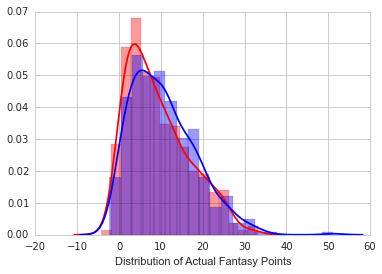

In [188]:
%matplotlib inline
from collections import Counter
from matplotlib import pyplot as plt
from storm.locals import *
import math
import statistics
import numpy as np
import pandas as pd
import seaborn as sns

from os import listdir
from os.path import isfile, join
from os import walk

flames_lames_database = create_database("sqlite:/home/bdetweiler/src/Data Science/brad-evans-analysis/db/flames_lames.db")
flames_lames_store = Store(flames_lames_database)

flames = flames_lames_store.find(FlamesLames, And(FlamesLames.FLAME_LAME == u'flames', FlamesLames.PLAYER_POSITION != u'DST')).order_by(Desc(FlamesLames.ACT_FANTASY_POINTS))
lames = flames_lames_store.find(FlamesLames, And(FlamesLames.FLAME_LAME == u'lames', FlamesLames.PLAYER_POSITION != u'DST')).order_by(Asc(FlamesLames.ACT_FANTASY_POINTS))

flames_min = int(math.floor(flames.min(FlamesLames.ACT_FANTASY_POINTS))) - 1
flames_max = int(math.floor(flames.max(FlamesLames.ACT_FANTASY_POINTS))) + 1
flames_mean = flames.avg(FlamesLames.ACT_FANTASY_POINTS)

flames_data = []
for flame in flames:
    flames_data.append(flame.ACT_FANTASY_POINTS)

flames_variance = statistics.variance(flames_data)

lames_min = int(math.floor(lames.min(FlamesLames.ACT_FANTASY_POINTS))) - 1
lames_max = int(math.floor(lames.max(FlamesLames.ACT_FANTASY_POINTS))) + 1
lames_mean = lames.avg(FlamesLames.ACT_FANTASY_POINTS)

lames_data = []
for lame in lames:   
    lames_data.append(lame.ACT_FANTASY_POINTS)
    
lames_variance = statistics.variance(lames_data)

dist = sns
dist.set_style('whitegrid')
dist.distplot(np.array(flames_data), color='Red', axlabel='Distribution of Actual Fantasy Points')
dist.distplot(np.array(lames_data), color='Blue')



print("Flames mean: " + str(flames_mean))
print("Flames variance: " + str(flames_variance))
print("Flames standard deviation: " + str(math.sqrt(flames_variance)))

print("Lames mean: " + str(lames_mean))
print("Lames variance: " + str(lames_variance))
print("Lames standard deviation: " + str(math.sqrt(lames_variance)))

flames_lames_store.close()

Interesting. Using Yahoo! Fantasy standard scoring, we see the distribution of actual fantasy points from Brad's Flames and Lames picks. The most interesting thing we can garner from this is that the distributions are strikingly similar. However, if Brad's picks were generally correct, they should be at opposite ends. But instead, it seems that his Lames are a lot better off than his Flames. 

Now, success and failure are relative terms, but at some point we need to draw a line in the sand. For me personally, less than 10 points is pretty lame. But a flame needs a little more kick, so I would set the bar at 15 points. 

So a good question to ask might be, what is the probability that Brad's Flames and Lames will pan out?

Or, mathematically, P(flame_pick >= 15) and P(lame_pick < 10)

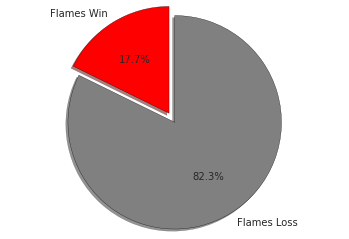

In [181]:
%matplotlib inline
from collections import Counter
from matplotlib import pyplot as plt
from storm.locals import *
import math
import numpy as np
import pandas as pd
import seaborn as sns

from os import listdir
from os.path import isfile, join
from os import walk

flames_lames_database = create_database("sqlite:/home/bdetweiler/src/Data Science/brad-evans-analysis/db/flames_lames.db")
flames_lames_store = Store(flames_lames_database)

flames = flames_lames_store.find(FlamesLames, And(FlamesLames.FLAME_LAME == u'flames', FlamesLames.PLAYER_POSITION != u'DST')).order_by(Desc(FlamesLames.ACT_FANTASY_POINTS))
lames = flames_lames_store.find(FlamesLames, And(FlamesLames.FLAME_LAME == u'lames', FlamesLames.PLAYER_POSITION != u'DST')).order_by(Asc(FlamesLames.ACT_FANTASY_POINTS))

flames_total = int(math.floor(flames.count(FlamesLames.ACT_FANTASY_POINTS)))
flames_win = 0
for flame in flames:
    if (flame.ACT_FANTASY_POINTS >= 15):
        flames_win += flame.ACT_FANTASY_POINTS

lames_total = int(math.floor(lames.count(FlamesLames.ACT_FANTASY_POINTS)))
lames_win = 0
for lame in lames:
    if (lame.ACT_FANTASY_POINTS < 10):
        lames_win += lame.ACT_FANTASY_POINTS


        

# The slices will be ordered and plotted counter-clockwise.
labels = 'Flames Win', 'Flames Loss'
sizes = [flames_total, flames_win]
colors = ['red', 'gray']
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')





flames_lames_store.close()

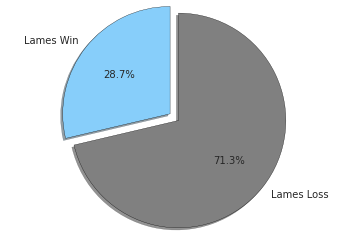

In [153]:
%matplotlib inline
from collections import Counter
from matplotlib import pyplot as plt
from storm.locals import *
import math
import numpy as np
import pandas as pd
import seaborn as sns

from os import listdir
from os.path import isfile, join
from os import walk

flames_lames_database = create_database("sqlite:/home/bdetweiler/src/Data Science/brad-evans-analysis/db/flames_lames.db")
flames_lames_store = Store(flames_lames_database)

flames = flames_lames_store.find(FlamesLames, And(FlamesLames.FLAME_LAME == u'flames', FlamesLames.PLAYER_POSITION != u'DST')).order_by(Desc(FlamesLames.ACT_FANTASY_POINTS))
lames = flames_lames_store.find(FlamesLames, And(FlamesLames.FLAME_LAME == u'lames', FlamesLames.PLAYER_POSITION != u'DST')).order_by(Asc(FlamesLames.ACT_FANTASY_POINTS))

flames_total = int(math.floor(flames.count(FlamesLames.ACT_FANTASY_POINTS)))
flames_win = 0
for flame in flames:
    if (flame.ACT_FANTASY_POINTS >= 15):
        flames_win += flame.ACT_FANTASY_POINTS

lames_total = int(math.floor(lames.count(FlamesLames.ACT_FANTASY_POINTS)))
lames_win = 0
for lame in lames:
    if (lame.ACT_FANTASY_POINTS < 10):
        lames_win += lame.ACT_FANTASY_POINTS




# The slices will be ordered and plotted counter-clockwise.
labels = 'Lames Win', 'Lames Loss'
sizes = [lames_total, lames_win]
colors = ['lightskyblue', 'gray']
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')


flames_lames_store.close()

As confirmed by our visual analysis, Brad is much better at Lames than he is at Flames. 

Let's take a look at the outliers.

In [176]:
%matplotlib inline
from collections import Counter
from matplotlib import pyplot as plt
from storm.locals import *
import math
import numpy as np
import pandas as pd
import seaborn as sns

from os import listdir
from os.path import isfile, join
from os import walk

flames_lames_database = create_database("sqlite:/home/bdetweiler/src/Data Science/brad-evans-analysis/db/flames_lames.db")
flames_lames_store = Store(flames_lames_database)

flames = flames_lames_store.find(FlamesLames, And(FlamesLames.FLAME_LAME == u'flames', FlamesLames.PLAYER_POSITION != u'DST')).order_by(Desc(FlamesLames.ACT_FANTASY_POINTS))
flames_max = flames.first()
flames_min = flames.last()

print("Flames Max (good): " + str(flames_max.GAME_DATE) + " - " + str(flames_max.ACT_FANTASY_POINTS) + " fantasy points, " + flames_max.PLAYER_FIRST_NAME + " " + flames_max.PLAYER_LAST_NAME + " (" + lames_max.PLAYER_POSITION + " - " + flames_max.PLAYER_TEAM + ")")
print("Brad sez: " + flames_max.BLURB)
print("")
print("Flames Min (bad): " + str(flames_min.GAME_DATE) + " - " + str(flames_min.ACT_FANTASY_POINTS) + " fantasy points, " + flames_min.PLAYER_FIRST_NAME + " " + flames_min.PLAYER_LAST_NAME + " (" + lames_min.PLAYER_POSITION + " - " + flames_min.PLAYER_TEAM + ")")
print("Brad sez: " + flames_min.BLURB)
print("")
lames = flames_lames_store.find(FlamesLames, And(FlamesLames.FLAME_LAME == u'lames', FlamesLames.PLAYER_POSITION != u'DST')).order_by(Desc(FlamesLames.ACT_FANTASY_POINTS))
lames_max = lames.first()
lames_min = lames.last()

print("Lames Max (bad): " + str(lames_max.GAME_DATE) + " - " + str(lames_max.ACT_FANTASY_POINTS) + " fantasy points, " + lames_max.PLAYER_FIRST_NAME + " " + lames_max.PLAYER_LAST_NAME + " (" + lames_max.PLAYER_POSITION + " - " + lames_max.PLAYER_TEAM + ")")
print("Brad sez: " + lames_max.BLURB)
print("")
print("Lames Min (good): " + str(lames_min.GAME_DATE) + " - " + str(lames_min.ACT_FANTASY_POINTS) + " fantasy points, " + lames_min.PLAYER_FIRST_NAME + " " + lames_min.PLAYER_LAST_NAME + " (" + lames_min.PLAYER_POSITION + " - " + lames_min.PLAYER_TEAM + ")")
print("Brad sez: " + lames_min.BLURB)
print("")


flames_lames_store.close()

Flames Max (good): 2013-12-15 - 33.18 fantasy points, Alex Smith (RB - KC)
Brad sez: Distancing himself from the game-manager stereotype, Smith has achieved relatively solid numbers in recent weeks without much fanfare. Since Week 7, he's averaged 220.4 passing yards and 25.4 rushing yards per game with five multi-score performances. His final tally suffered a bit last week in Washington largely due to an enormous early lead. As a result, he bled the clock, attempting only 20 passes. However, against an exploitable Oakland that impossibly made Geno Smith appear competent, he should deliver QB1 production when needed most. Over the past five weeks, only New England, Minnesota and Indy have been more generous to opposing signal callers than the Silver and Yack. Including Geno's four-TD improbable 23-point fantasy effort in standard Yahoo leagues, six passers have finished inside the QB top-12 against the Raiders this season. Oakland's highest-rated corner, Tracy Porter (63.0 catch%age al

Ouch, I remember that Doug Martin game. I played him! And with the exception of his 2011 season, I don't know if I'd ever call Nate Washington a flame. But to be fair, we could almost throw out that Doug Martin game altogether, for all intents and purposes, because it's not likely that something like that will ever happen again. 

